In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## Loading the data (MNIST)

In [34]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [35]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 60000


In [36]:
train_target[0].type()

'torch.cuda.LongTensor'

In [37]:
test_input.shape

torch.Size([10000, 1, 28, 28])

In [38]:
#train_input = train_input[0:10000]
#train_target = train_target[0:10000]

#test_input = test_input[0:10000]
#test_target = test_target[0:10000]

In [39]:
computeClassesWeights(train_target)

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [40]:
computeClassesWeights(test_target)

tensor([0.0980, 0.1135, 0.1032, 0.1010, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974,
        0.1009])

## 1) LeNet with disjoint trainset and testset

In [41]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [42]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00272920           0.915      0.00000584           0.982
10                   0.00007426           0.998      0.00000299           0.990
20                   0.00000728           1.000      0.00000237           0.993
29                   0.00000238           1.000      0.00000259           0.993
*******************************************************************************


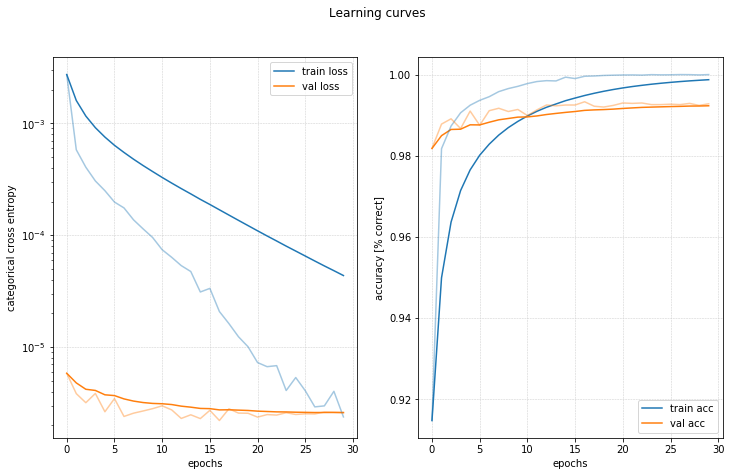

In [43]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 60
batch_fun = lambda x, y: x - 2*(y // batch_cap) * batch_cap

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=30, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [44]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [73]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [74]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -1.1261,   0.2319,  -2.2108,   8.2289,  -8.8106,  13.9956,  -5.1217,
          -4.9852,   4.3573,  -1.5158],
        [ 16.1048,  -5.2382,   1.3853,  -3.6267,  -7.9822,   2.5762,   1.2530,
           1.2929,  -5.4332,   3.9208],
        [ -6.9658,  -0.2990,   3.6982,   1.3166,  12.7887,  -3.0896,  -2.0600,
           2.0811,  -5.5891,   3.5318],
        [ -4.2202,  16.6430,   5.7847,  -4.7326,  -0.7825,  -9.9602,  -1.6584,
           4.1487,   3.8827,  -6.1504],
        [ -7.4407,  -1.0903,  -3.7515,  -1.2637,   7.1777,  -2.8158,  -7.9753,
           2.3371,   5.4118,  16.4798],
        [  1.9087,  -3.1865,  11.0889,   2.2133,  -8.3201,  -1.6184,  -2.6984,
           0.3635,   4.1818,   1.9694],
        [ -7.7393,  11.7036,   2.5693,  -0.2030,  -0.7769,  -1.3100,   0.1971,
           0.0766,   3.9108,  -2.7437],
        [ -0.8917,  -4.6641,   4.4691,  19.9583, -11.5973,   3.9280, -12.2253,
          -2.5459,   6.0714,   3.7880],
        [ -6.5266,  11.3777,   0.5818,  -2.0877,

In [75]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [76]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample (per classes)

In [45]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [46]:
layer = model.fc1
layer_name = "fc1"

In [47]:
g_train_dataset_classes, g_test_dataset_classes = \
generate_dataset_g_per_class(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7) 

In [48]:
choosen_class = 4
g_train_dataset = g_train_dataset_classes[choosen_class]
g_test_dataset = g_test_dataset_classes[choosen_class]

In [49]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of layer vector :", size_input_vector)

size of layer vector : 200


In [61]:
g_target_weigths = computeClassesWeights(g_train_dataset[1])
#g_target_weigths = np.abs(1-g_target_weigths).cuda()

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00104688           0.818      0.00029619           0.856
10                   0.00084840           0.856      0.00022151           0.856
20                   0.00081076           0.856      0.00022470           0.856
30                   0.00072166           0.857      0.00024287           0.854
40                   0.00064125           0.874      0.00027268           0.815
50                   0.00053348           0.896      0.00029888           0.822
60                   0.00044350           0.910      0.00035327           0.802
70                   0.00036509           0.928      0.00039067           0.791
80                   0.00029745           0.943      0.00047622           0.814
90                   0.00025195           0.954      0.00054814           0.772
99                   0.00021486         

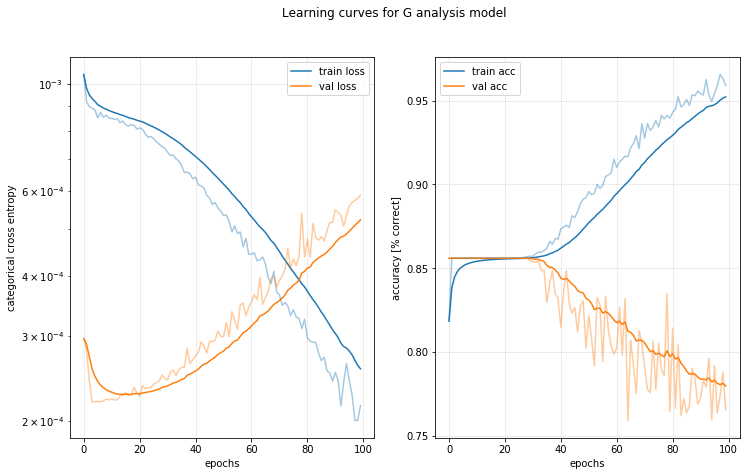

In [69]:
modelG = aliGs(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()#g_target_weigths)
learning_rate = 0.001

mt = ModelTrainer(modelG, loss_fun, optim.Adamax(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=100, batch_size=500, verbose=10)
mt.plot_training("Learning curves for G analysis model")

## 4) Train 10 shadow F models

In [19]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [20]:
train_step = train_dataset[0].shape[0]//10
test_step = test_dataset[0].shape[0]//10

In [21]:
shadow_train_inputs = list()
shadow_train_targets = list()
shadow_test_inputs = list()
shadow_test_targets = list()

shadow_train_datasets = list()
shadow_test_datasets = list()

for i in range(10):
    shadow_train_inputs.append(train_dataset[0][i*train_step:(i+1)*train_step])
    shadow_train_targets.append(train_dataset[1][i*train_step:(i+1)*train_step])
    shadow_train_datasets.append((shadow_train_inputs[i], shadow_train_targets[i]))
    
    shadow_test_inputs.append(test_dataset[0][i*test_step:(i+1)*test_step])
    shadow_test_targets.append(test_dataset[1][i*test_step:(i+1)*test_step])
    shadow_test_datasets.append((shadow_test_inputs[i], shadow_test_targets[i]))


training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !
training shadow model [5] ...done !
training shadow model [6] ...done !
training shadow model [7] ...done !
training shadow model [8] ...done !
training shadow model [9] ...done !


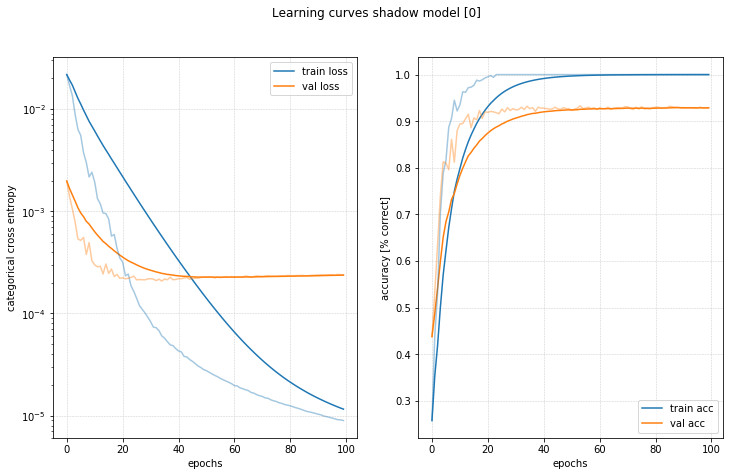

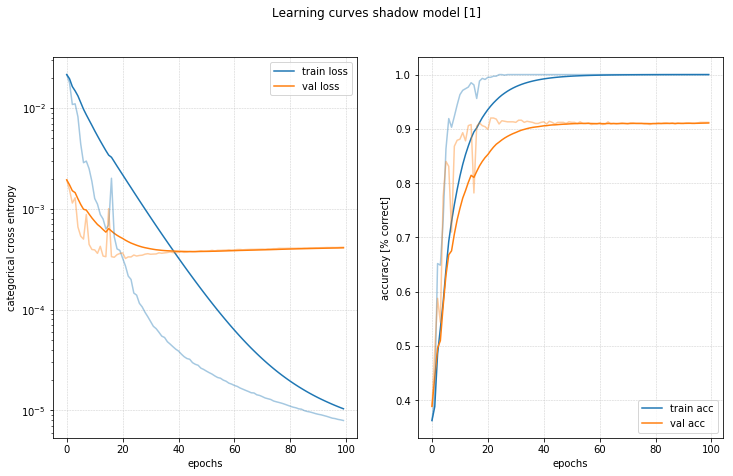

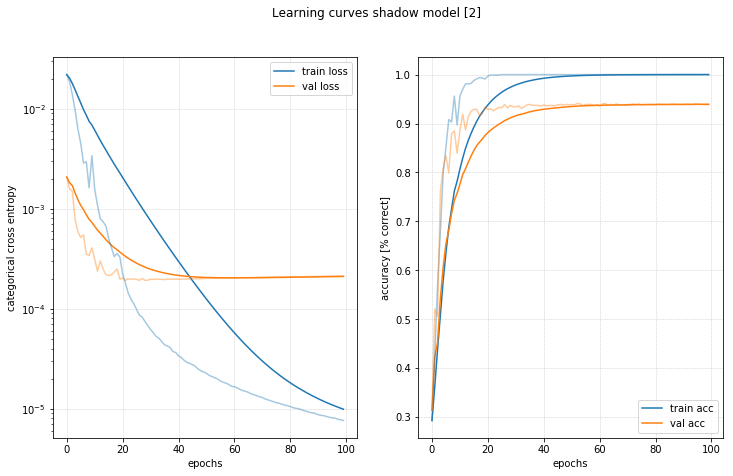

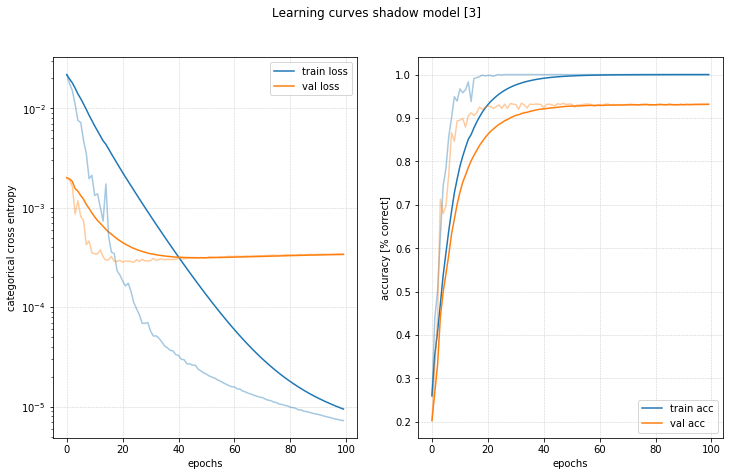

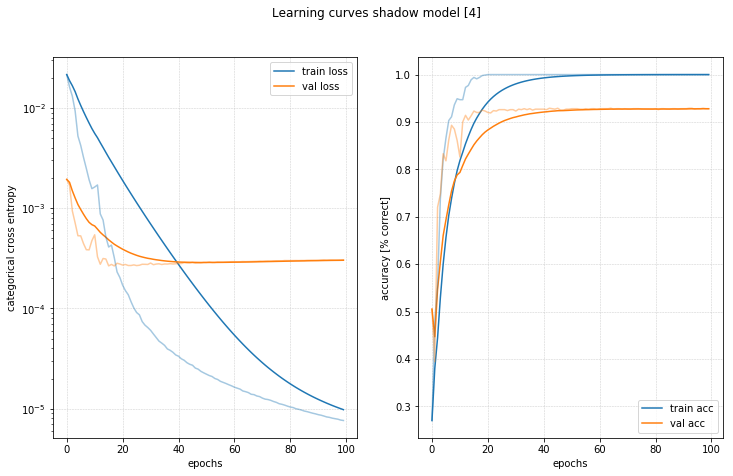

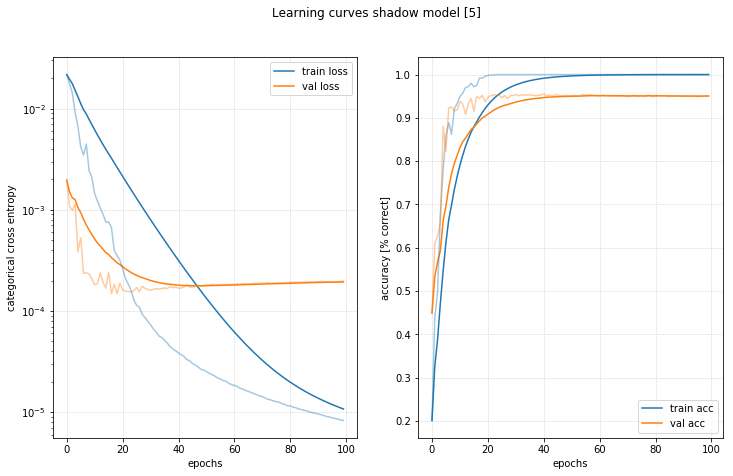

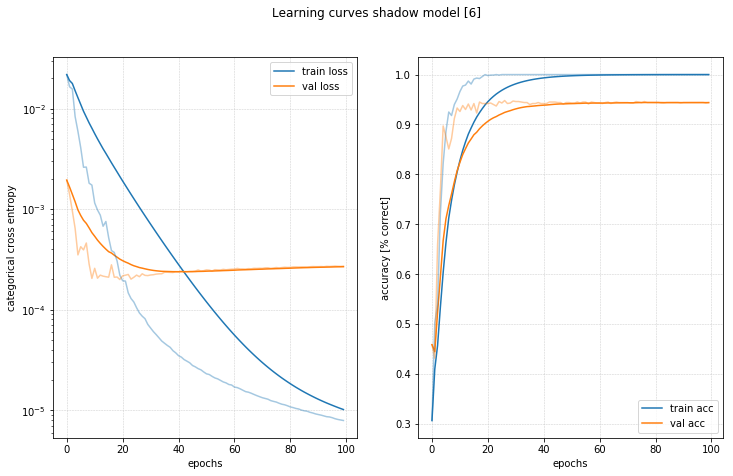

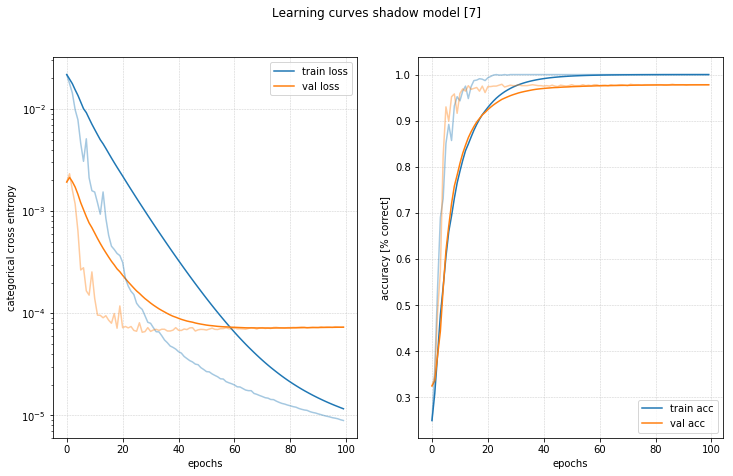

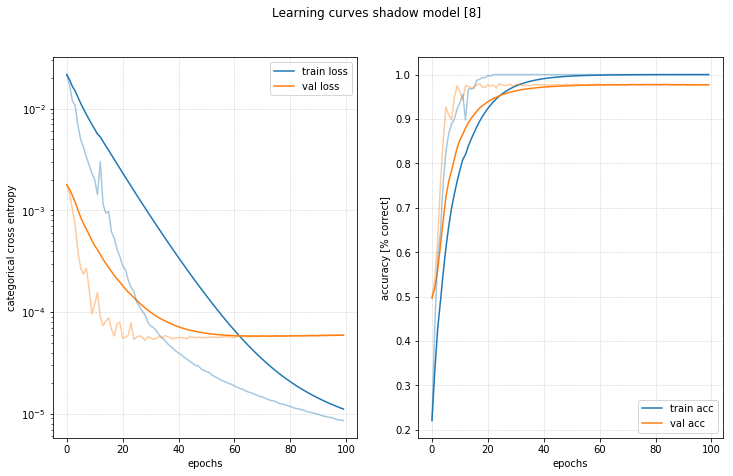

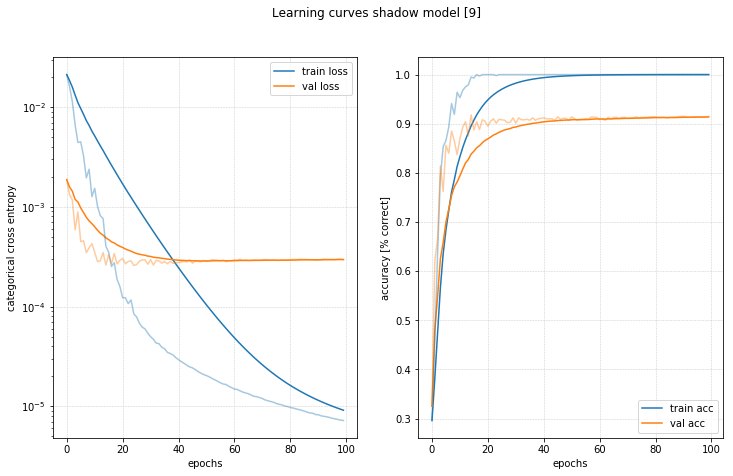

In [24]:
model_class = LeNet
shadow_models = list()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 100
batch_size = 100
verbose = 0

for i in range(10):
    print("training shadow model ["+str(i)+"] ...", end='')
    shadow_models.append(model_class())
    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")

In [25]:
for i in range(10):
    shadow_models[i].eval()

In [26]:
models = None

## 5) Generate shadow G datasets per classes

In [23]:
shadow_layers = list()
shadow_layers_names = list()
for i in range(10):
    shadow_layers.append(models[i].conv2)
    shadow_layers_names.append("shadow model ["+str(i)+"] layer conv2")

In [24]:
split = 0.7

shadow_g_train_input = train_input.new()
shadow_g_train_target = train_target.new()
shadow_g_test_input = test_input.new()
shadow_g_test_target = test_target.new()

for i in range(10):
    (tmp_g_train_input, tmp_g_train_target), (tmp_g_test_input, tmp_g_test_target) = \
    generate_dataset_g(models[i], shadow_train_datasets[i], shadow_test_datasets[i], [shadow_layers[i]], [shadow_layers_names[i]], split=split)
    
    shadow_g_train_input = torch.cat((shadow_g_train_input,tmp_g_train_input))
    shadow_g_train_target = torch.cat((shadow_g_train_target,tmp_g_train_target))
    
    shadow_g_test_input = torch.cat((shadow_g_test_input,tmp_g_test_input))
    shadow_g_test_target = torch.cat((shadow_g_test_target,tmp_g_test_target))
    
shadow_g_train_dataset = (shadow_g_train_input, shadow_g_train_target)
shadow_g_test_dataset = (shadow_g_test_input, shadow_g_test_target)

In [25]:
shadow_g_train_input.shape

torch.Size([14000, 1, 1024])

In [71]:
unique_classes = torch.unique(shadow_g_train_target)

In [78]:
shadow_g_train_input[shadow_g_train_target == 1].shape

torch.Size([7000, 1, 1024])